In [1]:
import torch
import numpy as np
import pandas as pd
import torchvision.transforms as transforms
from torchvision import models
from torchvision.datasets import ImageFolder
from torch import nn, optim
from torch.utils.data import DataLoader
from sklearn.metrics import precision_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
import json

# Function to load configurations
def load_config(config_file):
    with open(config_file, 'r') as file:
        config = json.load(file)
    return config

# Load the configuration
config = load_config('config/config.json')

# Access the dataset path
dataset_dir = config['dataset_path']
train_dir = config['train_path']
val_dir = config['val_path']
test_dir = config['test_path']

In [3]:
# Setup device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
# Data transformations
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Resize all images to 64x64
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

In [5]:
# Load training and validation data
train_data = ImageFolder(root=train_dir, transform=transform)
trainloader = DataLoader(train_data, batch_size=32, shuffle=True)

In [6]:
val_data = ImageFolder(root=val_dir, transform=transform)
valloader = DataLoader(val_data, batch_size=32, shuffle=False)

In [7]:
# Initialize the ResNet model
model = models.resnet101(pretrained=True)
num_classes = len(train_data.classes)
model.fc = nn.Linear(model.fc.in_features, num_classes)
model.to(device)

/opt/anaconda3/envs/Thesis/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/envs/Thesis/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [8]:
# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [9]:
number_of_epochs = 30

In [10]:
# Initialize a dictionary to store metrics
history = {
    'train_loss': [],
    'train_accuracy': [],
    'val_loss': [],
    'val_accuracy': [],
    'val_precision': []  # Ensure you add functionality to calculate precision if needed
}

In [11]:
for epoch in range(number_of_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for i, (inputs, labels) in enumerate(trainloader):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)

    epoch_train_loss = running_loss / total_train
    epoch_train_accuracy = 100 * correct_train / total_train
    history['train_loss'].append(epoch_train_loss)
    history['train_accuracy'].append(epoch_train_accuracy)

    model.eval()
    val_running_loss = 0.0
    correct_val = 0
    total_val = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in valloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            correct_val += (predicted == labels).sum().item()
            total_val += labels.size(0)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    val_loss = val_running_loss / total_val
    val_accuracy = 100 * correct_val / total_val
    val_precision = precision_score(all_labels, all_preds, average='macro')
    history['val_loss'].append(val_loss)
    history['val_accuracy'].append(val_accuracy)
    history['val_precision'].append(val_precision)

    print(f'Epoch {epoch + 1}/{number_of_epochs}')
    print(f'Train Loss: {epoch_train_loss:.4f}, Accuracy: {epoch_train_accuracy:.2f}%, Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%, Validation Precision: {val_precision:.4f}')

/opt/anaconda3/envs/Thesis/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/30
Train Loss: 0.6992, Accuracy: 52.06%, Loss: 0.9500, Val Accuracy: 42.86%, Validation Precision: 0.2143


/opt/anaconda3/envs/Thesis/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 2/30
Train Loss: 0.6320, Accuracy: 63.92%, Loss: 0.7392, Val Accuracy: 42.86%, Validation Precision: 0.2143


/opt/anaconda3/envs/Thesis/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 3/30
Train Loss: 0.5901, Accuracy: 63.92%, Loss: 0.8494, Val Accuracy: 42.86%, Validation Precision: 0.2143


/opt/anaconda3/envs/Thesis/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 4/30
Train Loss: 0.4760, Accuracy: 79.90%, Loss: 1.1088, Val Accuracy: 57.14%, Validation Precision: 0.2857


/opt/anaconda3/envs/Thesis/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 5/30
Train Loss: 0.4091, Accuracy: 82.47%, Loss: 1.2305, Val Accuracy: 42.86%, Validation Precision: 0.2143
Epoch 6/30
Train Loss: 0.2961, Accuracy: 87.63%, Loss: 0.6087, Val Accuracy: 67.86%, Validation Precision: 0.7339
Epoch 7/30
Train Loss: 0.1720, Accuracy: 96.91%, Loss: 0.5893, Val Accuracy: 71.43%, Validation Precision: 0.7083
Epoch 8/30
Train Loss: 0.1163, Accuracy: 98.97%, Loss: 0.6142, Val Accuracy: 78.57%, Validation Precision: 0.7857


/opt/anaconda3/envs/Thesis/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 9/30
Train Loss: 0.1000, Accuracy: 97.94%, Loss: 2.4806, Val Accuracy: 42.86%, Validation Precision: 0.2143
Epoch 10/30
Train Loss: 0.1094, Accuracy: 96.91%, Loss: 0.7752, Val Accuracy: 53.57%, Validation Precision: 0.5702
Epoch 11/30
Train Loss: 0.1305, Accuracy: 96.39%, Loss: 0.8279, Val Accuracy: 50.00%, Validation Precision: 0.6042
Epoch 12/30
Train Loss: 0.1312, Accuracy: 96.39%, Loss: 1.1399, Val Accuracy: 57.14%, Validation Precision: 0.7500
Epoch 13/30
Train Loss: 0.1238, Accuracy: 95.88%, Loss: 1.0026, Val Accuracy: 64.29%, Validation Precision: 0.7125
Epoch 14/30
Train Loss: 0.1169, Accuracy: 95.88%, Loss: 0.9688, Val Accuracy: 67.86%, Validation Precision: 0.7261
Epoch 15/30
Train Loss: 0.0919, Accuracy: 96.91%, Loss: 0.8557, Val Accuracy: 64.29%, Validation Precision: 0.6875
Epoch 16/30
Train Loss: 0.0988, Accuracy: 96.91%, Loss: 0.4498, Val Accuracy: 78.57%, Validation Precision: 0.7857
Epoch 17/30
Train Loss: 0.1006, Accuracy: 95.88%, Loss: 0.6843, Val Accuracy: 71.

In [12]:
file_name = f'Pth_Files/Resnet101_model_{number_of_epochs}.pth'

In [13]:
torch.save(model.state_dict(), file_name)

In [14]:
# Function to load the model
def load_model(file_name = f'Pth_Files/Resnet101_model_{number_of_epochs}.pth'):
    model = models.resnet101(pretrained=False)
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    model.load_state_dict(torch.load(file_name))
    model.to(device)
    model.eval()
    return model

In [15]:
from PIL import Image

# Function to preprocess and predict a new image
def predict_image(model, image_path):
    image = Image.open(image_path)
    transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    image = transform(image).unsqueeze(0)  # Add batch dimension
    image = image.to(device)
    with torch.no_grad():
        outputs = model(image)
        _, predicted = torch.max(outputs, 1)
        predicted_class = train_data.classes[predicted[0]]
        
    return predicted_class

In [16]:
image_1 = test_dir + "/edible/Agaricus_abruptibulbus/Agaricus_abruptibulbus_1.jpg"
image_2 = test_dir + "/poisonous/Amanita_excelsa/Amanita_excelsa_1.jpg"
image_3 = test_dir + "/edible/Agaricus_abruptibulbus/Agaricus_abruptibulbus_2.jpg"

In [17]:
# Example usage
print(f'The imag_1 is predicted as class: {predict_image(load_model(), image_1)}')
print(f'The imag_2 is predicted as class: {predict_image(load_model(), image_2)}')
print(f'The imag_3 is predicted as class: {predict_image(load_model(), image_3)}')

/opt/anaconda3/envs/Thesis/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/envs/Thesis/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


The imag_1 is predicted as class: edible
The imag_2 is predicted as class: edible
The imag_3 is predicted as class: edible


## Results

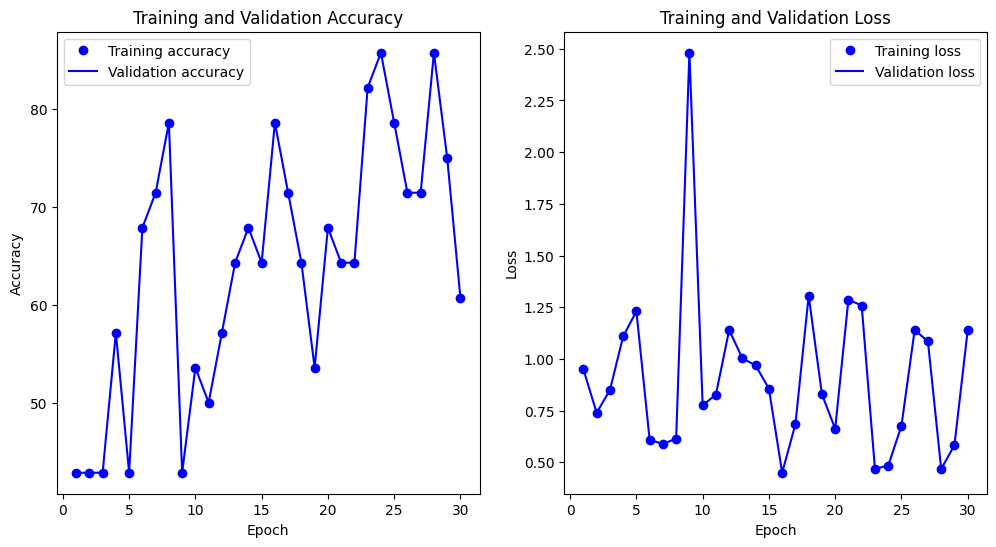

In [18]:
# Plot training & validation accuracy values
acc = history['val_accuracy']
val_acc = history['val_accuracy']
loss = history['val_loss']
val_loss = history['val_loss']
epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

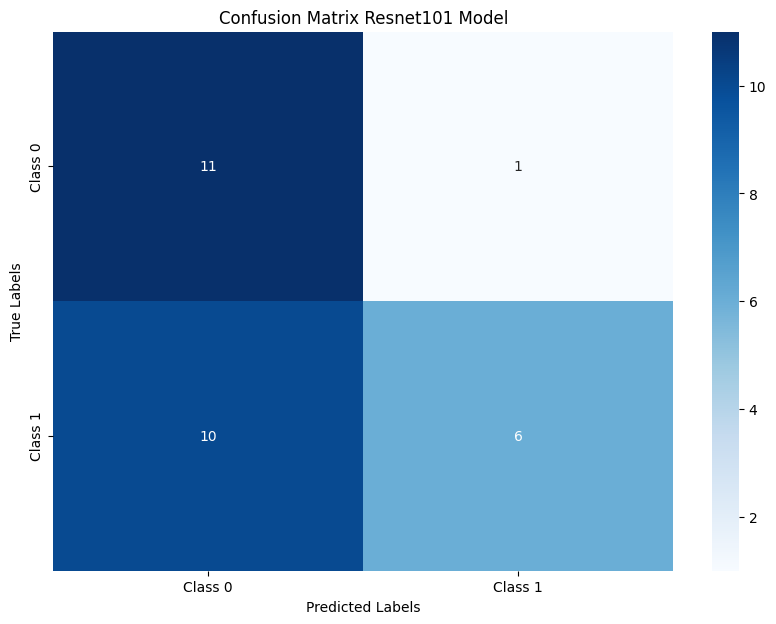

In [19]:
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.title('Confusion Matrix Resnet101 Model')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [20]:
cr = classification_report(all_labels, all_preds, target_names=['Class 0', 'Class 1'], output_dict=True)
df_cr = pd.DataFrame(cr).transpose()

print(df_cr)

              precision    recall  f1-score    support
Class 0        0.523810  0.916667  0.666667  12.000000
Class 1        0.857143  0.375000  0.521739  16.000000
accuracy       0.607143  0.607143  0.607143   0.607143
macro avg      0.690476  0.645833  0.594203  28.000000
weighted avg   0.714286  0.607143  0.583851  28.000000
